In [ ]:
!pip install --upgrade sympy
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 102.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [ ]:
import os
import tqdm
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load embeddings and metadata
AIME_embeddings_npy_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_AIME_Embeddings.npy"
AIME_metadata_csv_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/trimmedAIME_metadata.csv"
MusicCaps_embeddings_npy_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_MusicCaps_Embeddings.npy"
MusicCaps_metadata_csv_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/trimmedMusicCaps_metadata.csv"
AIME_embeddings = np.load(AIME_embeddings_npy_path)
AIME_metadata = pd.read_csv(AIME_metadata_csv_path)
MusicCaps_embeddings = np.load(MusicCaps_embeddings_npy_path)
MusicCaps_metadata = pd.read_csv(MusicCaps_metadata_csv_path)

AIME_wav2vec_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/Wav2Vec/AIME_time_embeddings.npz"
MusicCaps_wav2_vec_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/Wav2Vec/MusicCaps_time_embeddings.npz"
AIME_time_embeddings = np.load(AIME_wav2vec_path)
MusicCaps_time_embeddings = np.load(MusicCaps_wav2_vec_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
def create_embedding_lookup(keys, embeddings):
    return {key: embeddings[idx] for idx, key in enumerate(keys)}

# Create lookup for AIME and MusicCaps time embeddings
AIME_time_lookup = create_embedding_lookup(AIME_time_embeddings["file_names"], AIME_time_embeddings["time_embeddings"])
MusicCaps_time_lookup = create_embedding_lookup(MusicCaps_time_embeddings["file_names"], MusicCaps_time_embeddings["time_embeddings"])

## Neural Network

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, embedding_dim=512, use_extra_features=0):
        super(CombinedModel, self).__init__()
        input_dim = embedding_dim + use_extra_features

        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, combined_features, repetition_scores=None):
        x = combined_features
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, combined_features, labels):
        self.combined_features = combined_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.combined_features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

In [ ]:
def train_model(model, dataloader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for combined_features, labels in dataloader:
            combined_features = combined_features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            predictions = model(combined_features)
            loss = criterion(predictions.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            predicted_labels = (predictions.squeeze() > 0.5).float()
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

        epoch_losses.append(epoch_loss)
        epoch_accuracy = correct / total
        epoch_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return epoch_losses, epoch_accuracies

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for combined_features, labels in dataloader:
            combined_features = combined_features.to(device)
            labels = labels.to(device)

            outputs = model(combined_features)
            predictions.extend((outputs.squeeze() > 0.5).float().tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    return accuracy, cm

In [ ]:
print(f"AIME embeddings shape: {AIME_embeddings.shape}")
print(f"MusicCaps embeddings shape: {MusicCaps_embeddings.shape}")

AIME embeddings shape: (6500, 512)
MusicCaps embeddings shape: (5356, 512)


In [ ]:
# Labels: 1 for AI-generated, 0 for Human-composed
AIME_labels = np.ones(AIME_embeddings.shape[0])
MusicCaps_labels = np.zeros(MusicCaps_embeddings.shape[0])

# Balance the datasets
np.random.seed(42)
total_samples = min(AIME_embeddings.shape[0], MusicCaps_embeddings.shape[0])
print(f"Total samples: {total_samples}")
AIME_sampled_indices = np.random.choice(AIME_embeddings.shape[0], total_samples, replace=False)
MusicCaps_sampled_indices = np.random.choice(MusicCaps_embeddings.shape[0], total_samples, replace=False)

AIME_sampled = AIME_embeddings[AIME_sampled_indices]
MusicCaps_sampled = MusicCaps_embeddings[MusicCaps_sampled_indices]
AIME_labels_sampled = AIME_labels[AIME_sampled_indices]
MusicCaps_labels_sampled = MusicCaps_labels[MusicCaps_sampled_indices]
# AIME_json_metadata_sampled = [AIME_json_metadata[i]["file_name"].split(".")[0] for i in AIME_sampled_indices]
# MusicCaps_json_metadata_sampled = [MusicCaps_json_metadata[i]["file_name"].split(".")[0]  for i in MusicCaps_sampled_indices]

print(f"AIME sampled shape: {AIME_sampled.shape}")
print(f"MusicCaps sampled shape: {MusicCaps_sampled.shape}")

Total samples: 5356
AIME sampled shape: (5356, 512)
MusicCaps sampled shape: (5356, 512)


In [ ]:
# # CLAP Embeddings order
# with open("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_AIME_Embeddings.json", "r") as f:
#     AIME_json_metadata = json.load(f)
# with open("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_MusicCaps_Embeddings.json", "r") as f:
#     MusicCaps_json_metadata = json.load(f)

# def extract_time_embeddings(metadata, embedding_lookup):
#     aligned_time_embs = []
#     for entry in metadata:
#         file_name = entry["file_name"].split(".")[0]
#         if file_name in embedding_lookup:
#             aligned_time_embs.append(embedding_lookup[file_name])  # Direct lookup
#         else:
#             print(f"File {file_name} not found in time embeddings.")
#     return np.array(aligned_time_embs)

# AIME_aligned_time_embs = extract_time_embeddings(AIME_json_metadata, AIME_time_lookup)[AIME_sampled_indices]
# print(f"AIME aligned time embeddings shape: {AIME_aligned_time_embs.shape}")  # Should be [num_samples, 349, 768]
# MusicCaps_aligned_time_embs = extract_time_embeddings(MusicCaps_json_metadata, MusicCaps_time_lookup)[MusicCaps_sampled_indices]
# print(f"MusicCaps aligned time embeddings shape: {MusicCaps_aligned_time_embs.shape}")  # Should be [num_samples, 349, 768]

#### Features

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# def calculate_repetition_score(embedding, chunk_size=64):
#     # Divide the embedding into chunks
#     num_chunks = len(embedding) // chunk_size
#     chunks = np.array_split(embedding[:num_chunks * chunk_size], num_chunks)

#     # Compute pairwise cosine similarities
#     similarities = cosine_similarity(chunks)
#     # Extract upper triangular values (excluding diagonal)
#     repetition_score = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
#     return repetition_score

def calculate_repetition_score(embedding, chunk_size=16):
    num_chunks = embedding.shape[0] // chunk_size
    chunks = np.array_split(embedding[:num_chunks * chunk_size], num_chunks, axis=0)

    chunk_means = [np.mean(chunk, axis=0) for chunk in chunks]
    similarities = cosine_similarity(chunk_means)

    repetition_score = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
    return repetition_score

In [ ]:
# def calculate_mixing_quality_score(embedding):
#     # normalized_embedding = (embedding - np.mean(embedding)) / (np.std(embedding) + 1e-8)
#     variance = np.var(embedding, axis=1).mean()  # Average variance across time frames
#     # variance = np.var(embedding)
#     smoothness = np.var(np.diff(embedding, axis=0)) + 1e-4
#     # smoothness = np.var(np.diff(embedding))
#     mixing_quality_score = np.log1p(variance / (smoothness + 1e-8))  # Prevent division by zero
#     return mixing_quality_score

def calculate_mixing_quality_score(embedding):
    """
    Calculate mixing quality based on temporal energy distribution.

    Args:
        embedding (numpy.ndarray): Shape (time_frames, feature_dim).

    Returns:
        float: Refined mixing quality score.
    """
    # Compute energy per frame (sum of square of all features in each frame)
    frame_energies = np.sum(np.square(embedding), axis=1)
    frame_energies = (frame_energies - np.mean(frame_energies)) / (np.std(frame_energies) + 1e-8)

    # frame_entropy = -np.sum(frame_energies * np.log(frame_energies + 1e-8))



    # Measure variance across time (captures temporal energy distribution)
    energy_variance = np.var(frame_energies)

    # Temporal smoothness: Variance of differences between consecutive frames
    smoothness = np.var(np.diff(frame_energies))

    # Mixing quality score as a ratio
    #mixing_quality_score = frame_entropy / (smoothness + 1e-8)
    mixing_quality_score = np.log1p(energy_variance / (smoothness + 1e-8))  # Avoid divide by zero
    return mixing_quality_score


In [ ]:
# def calculate_distortion_score_internal(embedding, outlier_threshold=3):
#     """
#     Calculate a distortion score for an embedding based on its internal distribution.
#     Args:
#         embedding (numpy.ndarray): The audio embedding (1D array).
#         outlier_threshold (int): Threshold (in std devs) to define outliers.
#     Returns:
#         float: Distortion score.
#     """

#     std_dev = np.std(embedding, axis=1).mean()
#     num_outliers = np.sum(np.abs(embedding) > outlier_threshold * std_dev)
#     smoothness = np.var(np.diff(embedding, axis=0))
#     distortion_score = num_outliers + smoothness
#     return distortion_score

    # # Standard deviation of the embedding
    # std_dev = np.std(embedding)

    # # Count outliers (values beyond threshold * std_dev)
    # num_outliers = np.sum(np.abs(embedding) > outlier_threshold * std_dev)

    # # Smoothness: Variance of differences between consecutive values
    # smoothness = np.var(np.diff(embedding))

    # # Combine outlier count and smoothness into a distortion score
    # distortion_score = num_outliers + smoothness
    # return distortion_score

from scipy.stats import gmean

def calculate_distortion_score_internal(embedding):
    """
    Calculate distortion score based on spectral flatness.

    Args:
        embedding (numpy.ndarray): Shape (time_frames, feature_dim).

    Returns:
        float: Refined distortion score.
    """
    # Compute energy per frequency bin (average across time frames)
    spectral_energy = np.mean(np.square(embedding), axis=0)

    # Calculate spectral flatness (geometric mean / arithmetic mean)
    geometric_mean = gmean(spectral_energy + 1e-8)  # Avoid log(0) with small epsilon
    arithmetic_mean = np.mean(spectral_energy + 1e-8)
    spectral_flatness = geometric_mean / arithmetic_mean

    # Invert flatness to get "distortion-like" measure
    distortion_score = 1 - spectral_flatness
    return distortion_score



In [ ]:
def calculate_audio_scores(embedding):
    repetition_score = calculate_repetition_score(embedding)  # From earlier
    mixing_quality_score = calculate_mixing_quality_score(embedding)  # From earlier
    distortion_score = calculate_distortion_score_internal(embedding)  # Updated method

    return {
        "repetition_score": repetition_score,
        "mixing_quality_score": mixing_quality_score,
        "distortion_score": distortion_score
    }


In [ ]:
AIME_repetition_scores = []
AIME_mixing_quality_scores = []
AIME_distortion_scores = []

for i, embedding in enumerate(AIME_aligned_time_embs):
  # Assume we have an embedding and dataset centroid
  #print(f"Embedding {i+1}")

  # Calculate scores
  scores = calculate_audio_scores(embedding)
  AIME_repetition_scores.append(scores["repetition_score"])
  AIME_mixing_quality_scores.append(scores["mixing_quality_score"])
  AIME_distortion_scores.append(scores["distortion_score"])

In [ ]:
# print(f"AIME repetition scores shape: {np.array(AIME_repetition_scores).shape}")
# np.savez_compressed(
#         "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Features/AIME_features.npz",
#         AIME_repetition_scores=AIME_repetition_scores,
#         AIME_mixing_quality_scores=AIME_mixing_quality_scores,
#         AIME_distortion_scores=AIME_distortion_scores,
#     )
# print("Saved features to npz file.")

AIME repetition scores shape: (5356,)
Saved features to npz file.


In [ ]:
MusicCaps_repetition_scores = []
MusicCaps_mixing_quality_scores = []
MusicCaps_distortion_scores = []

for i, embedding in enumerate(MusicCaps_aligned_time_embs):
  # Assume we have an embedding and dataset centroid
  #print(f"Embedding {i+1}")

  # Calculate scores
  scores = calculate_audio_scores(embedding)
  MusicCaps_repetition_scores.append(scores["repetition_score"])
  MusicCaps_mixing_quality_scores.append(scores["mixing_quality_score"])
  MusicCaps_distortion_scores.append(scores["distortion_score"])

In [ ]:
# print(f"MusicCaps repetition scores shape: {np.array(MusicCaps_repetition_scores).shape}")
# np.savez_compressed(
#         "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Features/MusicCaps_features.npz",
#         MusicCaps_repetition_scores=MusicCaps_repetition_scores,
#         MusicCaps_mixing_quality_scores=MusicCaps_mixing_quality_scores,
#         MusicCaps_distortion_scores=MusicCaps_distortion_scores,
#     )
# print("Saved features to npz file.")

MusicCaps repetition scores shape: (5356,)
Saved features to npz file.


In [ ]:
AIME_features = np.load("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Features/AIME_features.npz")
MusicCaps_features = np.load("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Features/MusicCaps_features.npz")
# AIME_features = {"AIME_repetition_scores": AIME_repetition_scores, "AIME_mixing_quality_scores": AIME_mixing_quality_scores, "AIME_distortion_scores": AIME_distortion_scores}
# MusicCaps_features = {"MusicCaps_repetition_scores": MusicCaps_repetition_scores, "MusicCaps_mixing_quality_scores": MusicCaps_mixing_quality_scores, "MusicCaps_distortion_scores": MusicCaps_distortion_scores}

labels = [0] * 5356 + [1] * 5356
data = pd.DataFrame({
    "Repetition Score": np.concatenate([AIME_features["AIME_repetition_scores"], MusicCaps_features["MusicCaps_repetition_scores"]]).tolist(),
    "Mixing Quality Score": np.concatenate([AIME_features["AIME_mixing_quality_scores"], MusicCaps_features["MusicCaps_mixing_quality_scores"]]).tolist(),
    "Distortion Score": np.concatenate([AIME_features["AIME_distortion_scores"], MusicCaps_features["MusicCaps_distortion_scores"]]).tolist(),
    "Label": labels
})

# Separate AI and Human
ai_data = data[data["Label"] == 0]
human_data = data[data["Label"] == 1]

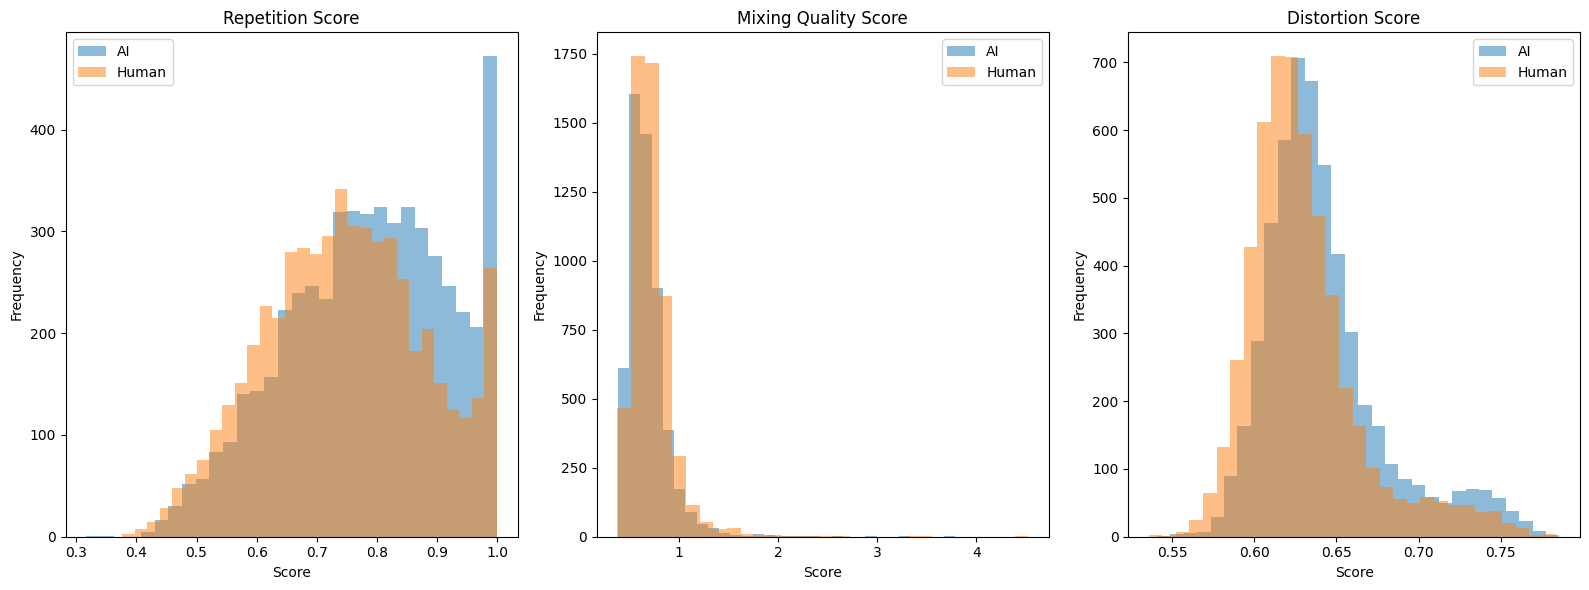

In [ ]:
# Plot distributions for each score
plt.figure(figsize=(16, 6))

for i, score in enumerate(["Repetition Score", "Mixing Quality Score", "Distortion Score"], 1):
    plt.subplot(1, 3, i)
    plt.hist(ai_data[score], bins=30, alpha=0.5, label="AI")
    plt.hist(human_data[score], bins=30, alpha=0.5, label="Human")
    plt.title(score)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()


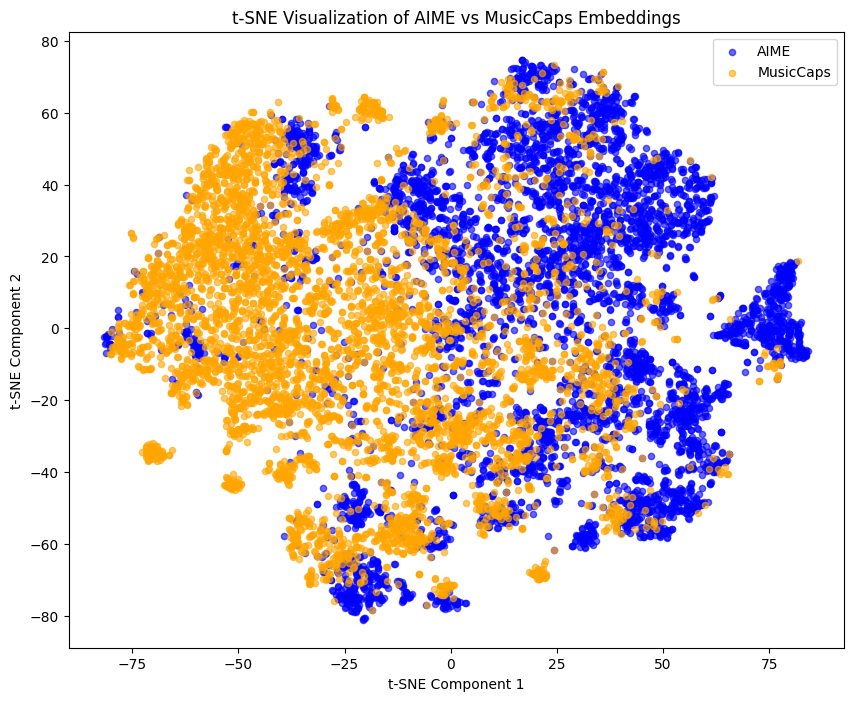

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine embeddings and create labels
combined_embeddings = np.concatenate([AIME_sampled, MusicCaps_sampled], axis=0)
labels = np.array([0] * len(AIME_sampled) + [1] * len(MusicCaps_sampled))  # 0 for AIME, 1 for MusicCaps

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(combined_embeddings)

# Separate t-SNE results for AIME and MusicCaps
tsne_aime = tsne_results[labels == 0]
tsne_musiccaps = tsne_results[labels == 1]

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_aime[:, 0], tsne_aime[:, 1], label="AIME", alpha=0.6, s=20, c="blue")
plt.scatter(tsne_musiccaps[:, 0], tsne_musiccaps[:, 1], label="MusicCaps", alpha=0.6, s=20, c="orange")

plt.title("t-SNE Visualization of AIME vs MusicCaps Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

In [ ]:
# Perform t-tests
from scipy.stats import ttest_ind
for score in ["Repetition Score", "Mixing Quality Score", "Distortion Score"]:
    t_stat, p_val = ttest_ind(ai_data[score], human_data[score], equal_var=False)
    print(f"{score}: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")


Repetition Score: t-statistic = 15.29, p-value = 0.0000
Mixing Quality Score: t-statistic = -4.28, p-value = 0.0000
Distortion Score: t-statistic = 17.55, p-value = 0.0000


In [ ]:
for i, score in enumerate(human_data["Mixing Quality Score"]):
  if score > 800:
    print(f"Index {i}: {score}")


In [ ]:
# Extract individual feature arrays
AIME_repetition_scores = AIME_features["AIME_repetition_scores"]
AIME_mixing_quality_scores = AIME_features["AIME_mixing_quality_scores"]
AIME_distortion_scores = AIME_features["AIME_distortion_scores"]

MusicCaps_repetition_scores = MusicCaps_features["MusicCaps_repetition_scores"]
MusicCaps_mixing_quality_scores = MusicCaps_features["MusicCaps_mixing_quality_scores"]
MusicCaps_distortion_scores = MusicCaps_features["MusicCaps_distortion_scores"]

# Combine features for AIME and MusicCaps
AIME_combined_features = np.column_stack((AIME_repetition_scores, AIME_mixing_quality_scores))
MusicCaps_combined_features = np.column_stack((MusicCaps_repetition_scores, MusicCaps_mixing_quality_scores))

# Combine into a single feature matrix
# all_features = np.vstack((AIME_combined_features, MusicCaps_combined_features))

all_features = np.vstack((AIME_distortion_scores.reshape(-1, 1), MusicCaps_distortion_scores.reshape(-1, 1)))


# Verify shape
print(f"All Features Shape: {all_features.shape}")

All Features Shape: (10712, 1)


Random:

In [ ]:
for i in range(10):
  # Assume we have an embedding and dataset centroid
  print(f"Embedding {i+1}")
  embedding = np.random.rand(512)  # Example embedding

  # Calculate scores
  scores = calculate_audio_scores(embedding)
  print("Repetition Score:", scores["repetition_score"])
  print("Mixing Quality Score:", scores["mixing_quality_score"])
  print("Distortion Score:", scores["distortion_score"])

Embedding 1
Repetition Score: 0.7565986600209308
Mixing Quality Score: 0.5148478781866288
Distortion Score: 69.1640195578731
Embedding 2
Repetition Score: 0.7337879190834025
Mixing Quality Score: 0.4915390915427653
Distortion Score: 66.16273327202916
Embedding 3
Repetition Score: 0.7777649019529165
Mixing Quality Score: 0.5353696891419474
Distortion Score: 80.15157178582326
Embedding 4
Repetition Score: 0.7522008879418918
Mixing Quality Score: 0.5140426128548982
Distortion Score: 62.17037784748667
Embedding 5
Repetition Score: 0.7679481015007532
Mixing Quality Score: 0.493613673480753
Distortion Score: 85.16991207617663
Embedding 6
Repetition Score: 0.7564908543027754
Mixing Quality Score: 0.49760175661662126
Distortion Score: 66.15835028781481
Embedding 7
Repetition Score: 0.7529021092077518
Mixing Quality Score: 0.49494404661210734
Distortion Score: 63.16852930572707
Embedding 8
Repetition Score: 0.7410606989767122
Mixing Quality Score: 0.5400425386239562
Distortion Score: 65.1491585

## Training

In [ ]:
# Combine datasets
all_embeddings = np.vstack([AIME_sampled, MusicCaps_sampled])
all_labels = np.concatenate([AIME_labels_sampled, MusicCaps_labels_sampled])
combined_features = np.hstack([all_features, all_embeddings])
print(f"Combined Features Shape: {combined_features.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(combined_features, all_labels, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Combined Features Shape: (10712, 513)
X_train shape: (8569, 513)
X_test shape: (2143, 513)
y_train shape: (8569,)
y_test shape: (2143,)


In [ ]:
# # Iterate through embeddings and corresponding features
# for i in range(len(all_embeddings)):
#     # Calculate scores for the current embedding
#     print(all_embeddings[i])
#     recalculated_scores = calculate_audio_scores(all_embeddings[i])

#     # Extract stored scores
#     stored_repetition = all_features[i, 0]
#     stored_mixing = all_features[i, 1]
#     stored_distortion = all_features[i, 2]

#     # Compare each score
#     if (
#         np.isclose(stored_repetition, recalculated_scores["repetition_score"]) and
#         np.isclose(stored_mixing, recalculated_scores["mixing_quality_score"]) and
#         np.isclose(stored_distortion, recalculated_scores["distortion_score"])
#     ):
#         # print(f"Embedding {i}: Scores match.")
#         continue
#     else:
#         print(f"Embedding {i}: Scores do not match.")
#         print(f"Stored: Repetition = {stored_repetition}, Mixing = {stored_mixing}, Distortion = {stored_distortion}")
#         print(f"Recalculated: Repetition = {recalculated_scores['repetition_score']}, Mixing = {recalculated_scores['mixing_quality_score']}, Distortion = {recalculated_scores['distortion_score']}")

In [ ]:
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
combined_model = CombinedModel(embedding_dim=all_embeddings.shape[1], use_extra_features=1).to(device)

print("Training model...")
combined_losses, combined_accuracies = train_model(combined_model, train_loader, num_epochs=50, learning_rate=1e-3)

Training model...
Epoch 1/50, Loss: 97.2856
Epoch 2/50, Loss: 69.6294
Epoch 3/50, Loss: 62.2662
Epoch 4/50, Loss: 56.4872
Epoch 5/50, Loss: 52.4335
Epoch 6/50, Loss: 48.2224
Epoch 7/50, Loss: 46.0287
Epoch 8/50, Loss: 42.4902
Epoch 9/50, Loss: 40.3240
Epoch 10/50, Loss: 37.5041
Epoch 11/50, Loss: 36.0714
Epoch 12/50, Loss: 35.0941
Epoch 13/50, Loss: 33.8021
Epoch 14/50, Loss: 31.5294
Epoch 15/50, Loss: 30.9224
Epoch 16/50, Loss: 27.9367
Epoch 17/50, Loss: 27.9869
Epoch 18/50, Loss: 26.3489
Epoch 19/50, Loss: 25.2451
Epoch 20/50, Loss: 24.6072
Epoch 21/50, Loss: 22.7716
Epoch 22/50, Loss: 21.6982
Epoch 23/50, Loss: 20.6910
Epoch 24/50, Loss: 21.3713
Epoch 25/50, Loss: 18.9385
Epoch 26/50, Loss: 19.5553
Epoch 27/50, Loss: 17.2783
Epoch 28/50, Loss: 18.0231
Epoch 29/50, Loss: 17.5652
Epoch 30/50, Loss: 16.9628
Epoch 31/50, Loss: 16.5655
Epoch 32/50, Loss: 14.5896
Epoch 33/50, Loss: 15.0116
Epoch 34/50, Loss: 15.7968
Epoch 35/50, Loss: 15.2705
Epoch 36/50, Loss: 15.0234
Epoch 37/50, Loss: 

In [ ]:
torch.save(combined_model.state_dict(), "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/models/combined_model_0008.pth")

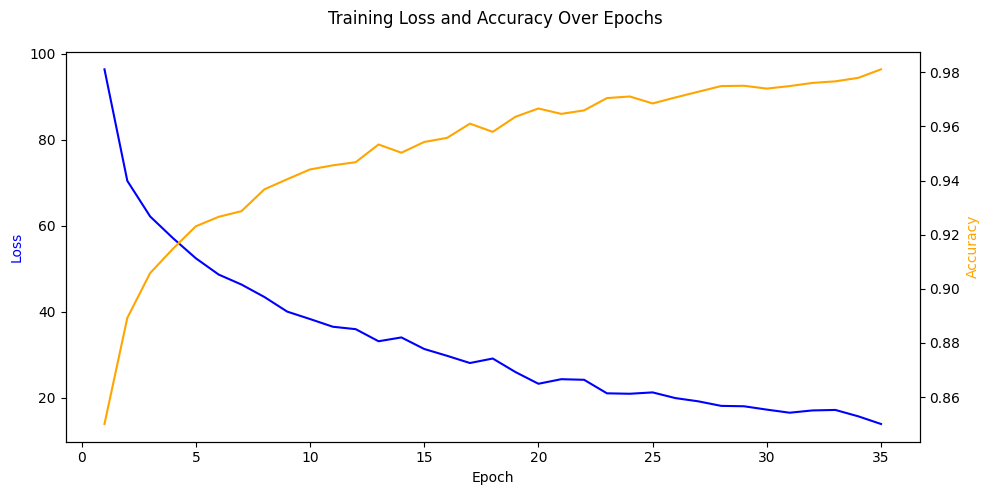

In [ ]:
epochs = range(1, len(combined_losses) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot loss
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="blue")
ax1.plot(epochs, combined_losses, label="Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="black")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="orange")
ax2.plot(epochs, combined_accuracies, label="Accuracy", color="orange")
ax2.tick_params(axis="y", labelcolor="black")

# Add a title and legend
fig.suptitle("Training Loss and Accuracy Over Epochs")
fig.tight_layout()

plt.show()

In [ ]:
print("Evaluating model...")
combined_model = CombinedModel(embedding_dim=all_embeddings.shape[1], use_extra_features=1).to(device)
combined_model.load_state_dict(torch.load("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/models/combined_model_0008.pth"))
combined_model.to(device)
accuracy, confusion_mat = evaluate_model(combined_model, test_loader)

Evaluating model...
Accuracy: 0.932
Precision: 0.954
Recall: 0.909
F1 Score: 0.931


<ipython-input-102-48a2685e2ef9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_model.load_state_dict(torch.load("/content/drive/MyDrive/MIT-Education/Junior Year

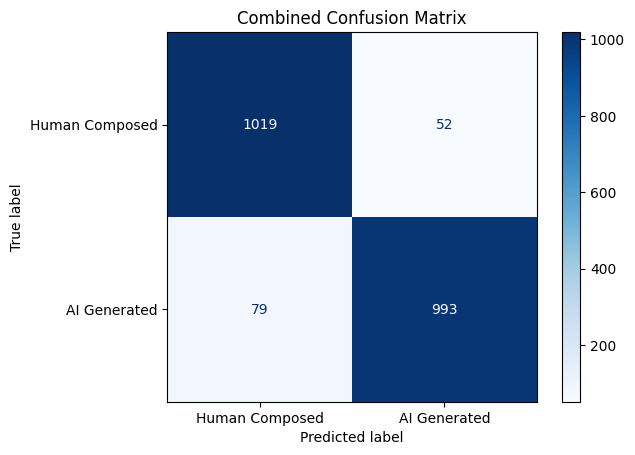

In [ ]:
# Plotting confusion matrix for test dataset
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["Human Composed", "AI Generated"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Combined Confusion Matrix")
plt.show()

# Old

In [ ]:
# Define the model
model = AudioClassificationModel(embedding_dim=512)  # Include repetition score
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        embeddings = X_batch[:, :-1]  # Embedding part
        repetition_scores = X_batch[:, -1]  # Repetition score part

        optimizer.zero_grad()
        predictions = model(embeddings, repetition_scores)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

Epoch 1/15, Loss: 3.5191
Epoch 2/15, Loss: 3.4989
Epoch 3/15, Loss: 3.4098
Epoch 4/15, Loss: 3.3256
Epoch 5/15, Loss: 3.2214
Epoch 6/15, Loss: 3.0487
Epoch 7/15, Loss: 2.9531
Epoch 8/15, Loss: 2.6349
Epoch 9/15, Loss: 2.3182
Epoch 10/15, Loss: 2.2604
Epoch 11/15, Loss: 2.0698
Epoch 12/15, Loss: 1.5325
Epoch 13/15, Loss: 1.2784
Epoch 14/15, Loss: 1.0959
Epoch 15/15, Loss: 1.0061


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        embeddings = X_batch[:, :-1]
        repetition_scores = X_batch[:, -1]

        outputs = model(embeddings, repetition_scores).squeeze()
        predictions = (outputs >= 0.5).int()

        y_true.extend(y_batch.tolist())
        y_pred.extend(predictions.tolist())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


Accuracy: 0.55, Precision: 0.80, Recall: 0.53, F1: 0.64
